In [ ]:
import pandas as pd
import numpy as np

# load dataset
merged = pd.read_csv(r"soil_moisture_merged.csv")

# preview
merged.head()

,AEZ_NAME,week_start,sm_surface,VV,VH,NDVI,LST,Rainfall_7d,Rainfall_7d_lag,ET,LAI,NDWI,NDMI,Temp_7d,Temp_7d_lagged,landcover,elevation,slope
0,Active Tista Floodplain,2022-01-01,0.159142,-5.761691,-13.478774,0.5488,22.31,3.705716,2.430984,8.2,0.6,0.041381,0.261766,17.507983,17.870370,40,33,1.386612
1,Tista Meander Floodplain,2022-01-01,0.152997,-7.386647,-16.112829,0.4492,23.41,4.648317,0.000000,7.5,0.6,-0.025512,0.127510,17.625635,17.970898,40,30,2.963912
2,Karatoya-Bangali Floodplain,2022-01-01,0.101049,-9.252055,-16.693300,0.4091,23.61,0.000000,0.000000,10.5,0.6,0.064735,0.241161,17.894887,18.837795,10,17,0.927410
3,Lower Atrai Basin,2022-01-01,0.107364,-9.480288,-18.177580,0.2117,23.75,6.558670,0.000000,10.5,0.2,0.022280,0.228830,17.792813,18.636809,40,13,1.378362
4,Active Brahmaputra-Jamuna Floodplain,2022-01-01,0.100783,-8.074512,-16.009851,0.4884,23.81,4.167820,2.591343,8.0,0.6,0.108474,0.320618,18.043685,18.809614,40,18,2.044861


## Week- Ahead Forecasting

In [ ]:
merged['week_start'] = pd.to_datetime(merged['week_start'])

# sort
merged = merged.sort_values(['AEZ_NAME', 'week_start']).reset_index(drop=True)

# for each AEZ, shifting the sm_surface by -1 (next week)
merged['sm_surface_nextweek'] = merged.groupby('AEZ_NAME')['sm_surface'].shift(-1)

# drop wherever found that next week target is missing
forecast_df = merged.dropna(subset=['sm_surface_nextweek']).copy()

print(f"Forecasting data shape: {forecast_df.shape}")
forecast_df.head()

Forecasting data shape: (2616, 19)


,AEZ_NAME,week_start,sm_surface,VV,VH,NDVI,LST,Rainfall_7d,Rainfall_7d_lag,ET,LAI,NDWI,NDMI,Temp_7d,Temp_7d_lagged,landcover,elevation,slope,sm_surface_nextweek
0,Active Brahmaputra-Jamuna Floodplain,2022-01-01,0.100783,-8.074512,-16.009851,0.4884,23.81,4.167820,2.591343,8.00,0.60,0.108474,0.320618,18.043685,18.809614,40,18,2.044861,0.105468
1,Active Brahmaputra-Jamuna Floodplain,2022-01-15,0.105468,-8.353654,-16.558287,0.3791,20.89,4.088538,4.371019,8.50,0.60,0.220710,0.488441,17.503373,19.310566,40,18,2.044861,0.138827
2,Active Brahmaputra-Jamuna Floodplain,2022-01-22,0.138827,-9.014642,-16.770062,0.3791,19.89,0.000000,4.088538,9.00,1.10,0.289103,0.536219,17.327510,17.503373,40,18,2.044861,0.162265
3,Active Brahmaputra-Jamuna Floodplain,2022-01-29,0.162265,-9.151098,-18.230369,0.4182,20.84,0.000000,0.000000,8.50,0.80,0.289103,0.536219,16.933177,17.327510,40,18,2.044861,0.199486
4,Active Brahmaputra-Jamuna Floodplain,2022-02-05,0.199486,-8.847391,-17.307298,0.4182,22.57,0.000000,0.000000,8.05,0.65,0.288752,0.563878,16.497508,16.933177,40,18,2.044861,0.181914


In [ ]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# features for RF (5 features)
features_rf_5 = [
    'ET', 'elevation', 'Rainfall_7d_lag', 'slope', 'Temp_7d_lagged'
]

# features for LightGBM
features_lgb = forecast_df.columns.difference([
    'sm_surface', 'AEZ_NAME', 'week_start', 'sm_surface_nextweek'
])

# define X and y for RF and LightGBM
X_rf = forecast_df[features_rf_5]
y = forecast_df['sm_surface_nextweek']

X_lgb = forecast_df[features_lgb]

# train-test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y, test_size=0.2, random_state=42, shuffle=True
)

X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(
    X_lgb, y, test_size=0.2, random_state=42, shuffle=True
)

# Random Forest Training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict using Random Forest
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

# LightGBM Training
# Dataset for LightGBM
train_data_lgb = lgb.Dataset(X_train_lgb, label=y_train_lgb)
test_data_lgb = lgb.Dataset(X_test_lgb, label=y_test_lgb, reference=train_data_lgb)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'random_state': 42
}

# Train LightGBM model
model_lgb = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=200,
    valid_sets=[test_data_lgb],
    early_stopping_rounds=20,
    verbose_eval=False 
)

# Predict using LightGBM
y_pred_lgb = model_lgb.predict(X_test_lgb, num_iteration=model_lgb.best_iteration)

# Evaluate LightGBM
rmse_lgb = np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test_lgb, y_pred_lgb)
r2_lgb = r2_score(y_test_lgb, y_pred_lgb)

# Results
print("== Random Forest Results ==")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE : {mae_rf:.3f}")
print(f"R²  : {r2_rf:.2f}")

print("\n== LightGBM Results ==")
print(f"RMSE: {rmse_lgb:.3f}")
print(f"MAE : {mae_lgb:.3f}")
print(f"R²  : {r2_lgb:.2f}")

== Random Forest Results ==
RMSE: 0.065
MAE : 0.048
R²  : 0.66

== LightGBM Results ==
RMSE: 0.053
MAE : 0.040
R²  : 0.78


C:\Users\Admin\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


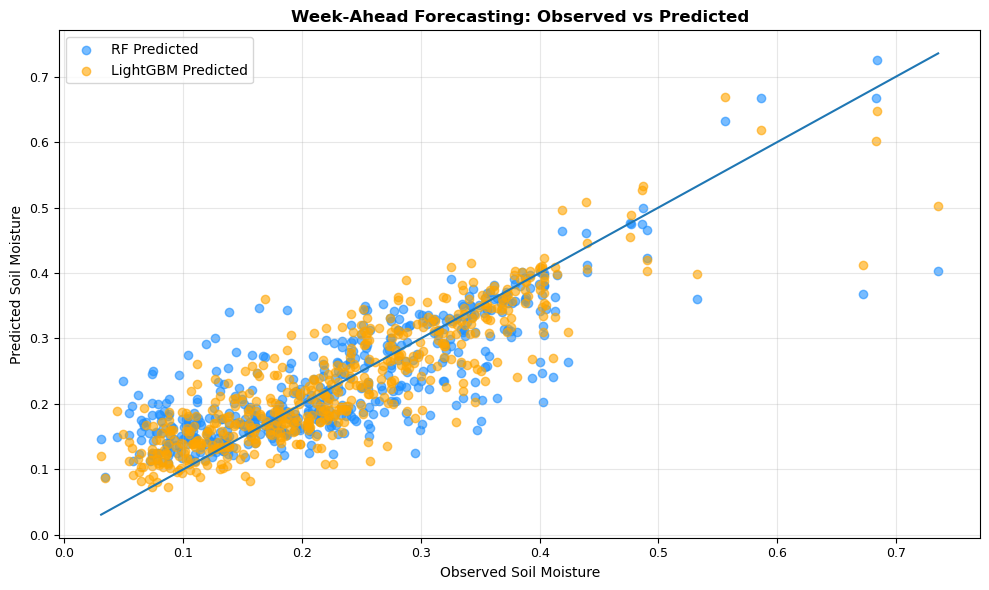

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of Observed vs Predicted for Random Forest
plt.figure(figsize=(10, 6))

# Plotting RF Predictions
plt.scatter(y_test_rf, y_pred_rf, color="dodgerblue", alpha=0.6, label="RF Predicted")

# Plotting LightGBM Predictions
plt.scatter(y_test_lgb, y_pred_lgb, color="orange", alpha=0.6, label="LightGBM Predicted")

# Adding perfect prediction line (y = x), where observed = predicted
plt.plot([min(y_test_rf.min(), y_test_lgb.min()), max(y_test_rf.max(), y_test_lgb.max())],
         [min(y_test_rf.min(), y_test_lgb.min()), max(y_test_rf.max(), y_test_lgb.max())])

# Labels and Title
plt.xlabel("Observed Soil Moisture", fontsize=10)
plt.ylabel("Predicted Soil Moisture", fontsize=10)
plt.title("Week-Ahead Forecasting: Observed vs Predicted", fontsize=12, fontweight='bold')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('03.Soil_moisture_forecast.png', dpi=600)
plt.show()

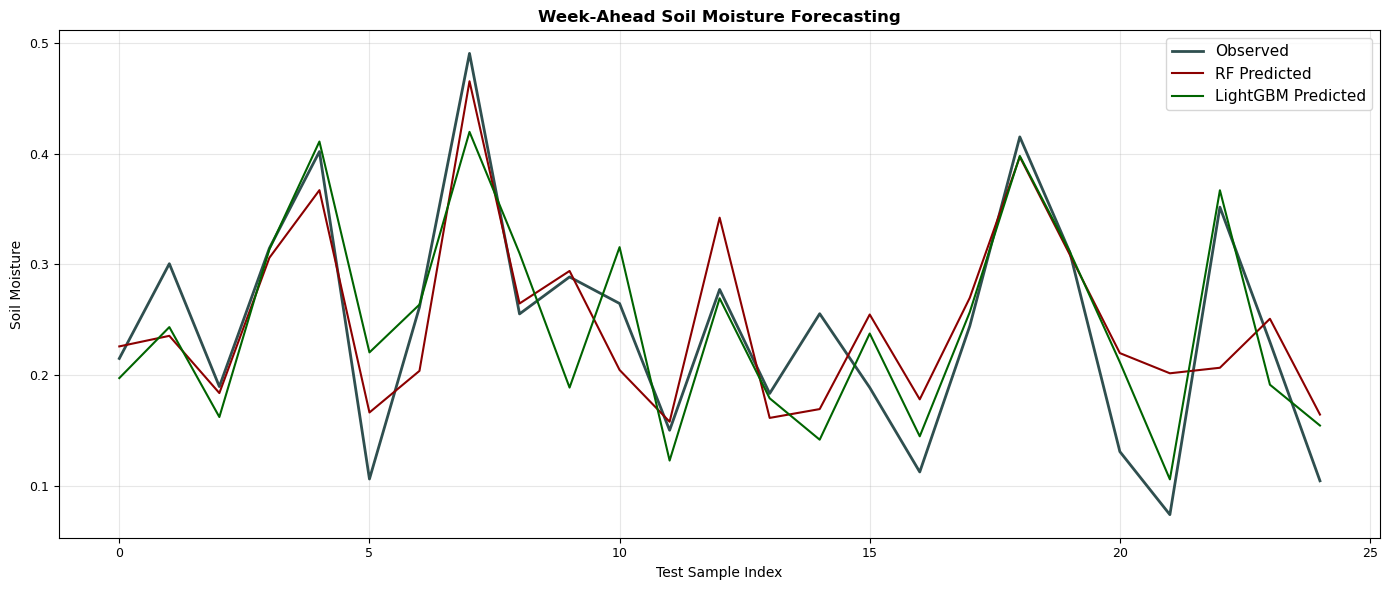

In [ ]:
import matplotlib.pyplot as plt

# colors for the plot
colors = {
    'observed': '#2F4F4F',  
    'rf_predicted': '#8B0000',  
    'lgb_predicted': '#006400'
}

plt.figure(figsize=(14, 6))

# Plotting Observed values (RF and LightGBM predictions)
plt.plot(y_test_rf.values[:25], label="Observed", color=colors['observed'], linewidth=2)
plt.plot(y_pred_rf[:25], label="RF Predicted", color=colors['rf_predicted'], linewidth=1.5)
plt.plot(y_pred_lgb[:25], label="LightGBM Predicted", color=colors['lgb_predicted'], linewidth=1.5)

# Title and labels
plt.title("Week-Ahead Soil Moisture Forecasting", fontsize=12, fontweight='bold')
plt.xlabel("Test Sample Index", fontsize=10)
plt.ylabel("Soil Moisture", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(fontsize=11, framealpha=0.8, loc='best')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("04.Forecasting_time_plot.png", dpi=600)

plt.show()